<small><i>This notebook was put together by [Abel Meneses](http://www.menesesabad.com) for PyData 2018. Source and license info is on [GitHub](https://github.com/sorice/nlp_pydata2018/).</i></small>

# Advanced Preprocessing: Luhn Eg.

Esta sección es una sección avanzada sobre NLP y sus procesos básicos. 
En las secciones anteriores hemos filtrado 
los stopwords que son palabras sin contenido semántico y las más frecuentes, en el 
caso del steamming se elimina algunos sufijos y se puede hacer con expresiones regulares
o basados en reglas. En cualquiera de estos casos la estadística es fundamental para 
el algoritmo o para el mecanismo de aprendizaje a utilizar. Y en todos los pasos vimos
como se reduce el número de palabras tratando de encontrar las más importantes.

Veamos ahora un ejemplo de NLP un área de la computación muy relacionada, **Information 
Retrieval** (*o Recuperación de Información*). Se trata de la *Ley de Luhn*[[2](#Luhn1958)], o el 
hallazgo de la banda de las palabras más importantes de un documento.

## Roadmap Summary

###  Datasets

Para todos los ejemplos se usarán dos libros, uno en inglés y otro en español. El 
primero es **Free Software Free Society** y el segundo una traducción de este primero
**Software Libre para una Sociedad Libre**.

### Transforming Dataset Texts

Generalmente casi todos los materiales que poseemos son *PDFs* y para operar con textos
en python lo mejor es usar .txt o formatos no enriquecidos. ¿Cómo transformar PDF
en TXT?

Nuestra recomendación es usar pypdf2 que aparece en los repositorios de GNU/Linux.
(ver [Text Extraction with pdfMiner](02.1-Text-Extraction-with-PDFMiner.ipynb))
Si conocen algún escript adecuado para esta tarea
utilizando la biblioteca *ghostscript* la recomendamos por encima de *pdftotext*. Sin 
embargo es bastante difícil encontrar semejante script _personalizado_ para nuestras
necesidades.

La biblioteca preprocess en su v0.2 incluye una función auxiliar que hace un wrapper de
la biblioteca pypdf2 para extraer el texto.

```python
from preprocess.io import pdf
PDF = pdf('/path/to/pdf/file.pdf')
text = PDF.extractText() 
with open('/path/for/new/archivo.txt','w') as doc:
    doc.write(text)
```
Sí estás usando preprocess v0.1 utiliza _pdftotext_ incluído en el paquete poppler-utils.

```bash
~$ pdftotext archivo.pdf
```

**Resultado:** archivo.txt

Hay que tener en cuenta que los scripts de *extracción de textos* generan los .txt
con muchos problemas: fundamentalmente caracteres extraños.
Tal vez resultará más útil para el lector estudiar aplicaciones y bibliotecas más 
especializadas para este tipo de problema del procesamiento de textos como: Apache-Tika,
u otros. Sin embargo en el tema anterior sobre pre-procesamiento, el lector podrá
encontrar como resolver estos problemas sin usar grandes bibliotecas
para un buen trabajo con los ejemplos básicos de NLP que se ofrecen a continuación.

## Transforming Text

The next codes transform text to allow the application of statistical analysis to build Luhn model.

In [1]:
#SoftwareWars2.txt is a normalized version of SoftwareWars.txt
texto = open('data/SoftwareWars2.txt').read().lower()

In [2]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("\s+", gaps=True)
tokens = tokenizer.tokenize(texto)
print ("Total de palabras: ", len(tokens))

Total de palabras:  102721


En ambos casos se devuelve el total de palabras(o tokens) divididos por el caracter
*espacio*. Sin embargo las palabras en un texto se repiten. ¿Cómo saber las palabras
únicas?

In [3]:
tokens_unique=set([])
tokens_unique = set(tokens)
print ("Palabras únicas:", len(tokens_unique))

Palabras únicas: 10127


Como se puede ver en el libro Bird et al.[[1](#Bird2009)] la pregunta más simple y 
común que se hace uno al ver estas cifras suelen ser: ¿Cuál es el promedio de palabras
por página? ¿Cuál es la palabra más utilizada? ¿Qué palabras se usan una vez? Veamos
algunas formas de calcularlo, para ello necesitaremos algunas funciones extras:

<a id='sect2.5'></a>

In [4]:
#Inicializar un diccionario para guardar el # de apariciones de cada palabra.
dict = {}
for word in tokens_unique:
    dict[word]=0
#Diccionario con word = # apariciones.
for token in tokens:
    dict[token]+=1
#Operar con una tupla puede ser mejor. Lista([#apariciones,word])
tupla = []
for word in dict:
    tupla.append([dict[word],word])

Esta tupla puede ser ordenada de la siguiente forma: al poner el # de apariciones 
delante, podemos usar el elemento *tupla[i][0]* como parámetro de ordenamiento.

In [5]:
tupla=sorted(tupla)
print ("Las 5 palabras más utilizadas son:")
for i in range(1,6):
    print (tupla[-i][1],":",tupla[-i][0])

Las 5 palabras más utilizadas son:
. : 5590
the : 4795
to : 2645
of : 2510
a : 2445


In [6]:
import time
from nltk.corpus import stopwords
timei = time.time()
english_stops = set(stopwords.words('en'))
tokens_afterstops=[]
for k in range(len(tokens)-1):
    if tokens[k] not in english_stops and len(tokens[k])>1:
        tokens_afterstops.append(tokens[k])
timef = time.time()-timei
print ("Tiempo de filtrado de stopwords: ",timef)

tokens_unique1 = set(tokens_afterstops)
dict1 = {} #dict con keys = set de tokens after stops
for word in tokens_unique1:
    dict1[word]=0

tupla1 = [] #Creando lista de tuplas(# ocurrencias,word) sin stopwords
for token in tokens_afterstops:
    dict1[token]+=1
for word in dict1:
    tupla1.append([dict1[word],word])
tupla1=sorted(tupla1)

print ("Palabras únicas sin stops:", len(tokens_unique1))
print ("Las 5 palabras más utilizadas después de filtrar los stopwords son:")
for i in range(1,6):
    print (tupla1[-i][1],":",tupla1[-i][0])
print ("Total de palabras del texto: ", len(tokens))
print ("Palabras en el texto sin stopwords:", len(tokens_afterstops))
print ("Palabras eliminadas en el proceso de filtrado de stopwords:", 
len(tokens)-len(tokens_afterstops))

Tiempo de filtrado de stopwords:  0.09764742851257324
Palabras únicas sin stops: 9970
Las 5 palabras más utilizadas después de filtrar los stopwords son:
software : 911
free : 638
linux : 467
code : 414
microsoft : 378
Total de palabras del texto:  102721
Palabras en el texto sin stopwords: 53825
Palabras eliminadas en el proceso de filtrado de stopwords: 48896


## Luhn Model in Linguistics

Luhn planteó que los textos se comportan como una función logarítmica negativa o una
función de cola larga. Donde los stopwords están al inicio, y las palabras poco 
frecuentes que tampoco definen el contexto están al final. Veamos una gráfica de este
libro. Usando la variable *tupla* de la sección de código [2.5](#sect2.5) construimos
un arreglo de *numpy* del cual se extrae la media($\mu$) y la varianza($\sigma$), 
valores que posteriormente se usarán en muchos cálculos.

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


10.1432803397
99.4680087938
(10127,)


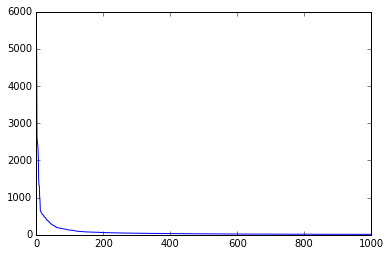

In [8]:
import scipy
xarray = []
t=scipy.linspace(0,len(tupla),num=len(tupla))
for i in range(len(tupla)):
    xarray.append(tupla[i][0])
xarray.reverse()

x = numpy.array(xarray,dtype=numpy.int16)
mux = x.mean()
sigmax = x.std()
print (mux) 
print (sigmax)
print (x.shape)

plt.plot(t[:1000],x[:1000])
plt.show()

**Ejemplo Experimental de Luhn**

### 1er paso: Generar distribución zeta de prueba.

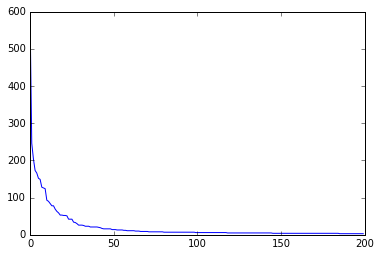

In [9]:
dist = np.random.zipf(2,size=1000)              # generar distribución zeta
dist = np.fix(dist)                             # dist zeta aproximada
dist1=np.sqrt(dist**2)                          # del negative values
dist2 = np.array(dist1,dtype=np.int16)          # llevado a enteros
dist3 = np.sort(dist2,axis=None,kind='mergesort') # ordenados de menor a mayor
mu = dist2.mean()
sigma = dist2.std()
dist3[:]=dist3[::-1]                            # ordenado de mayor a menor
plot(t[:200],dist3[:200])

### 2do paso: Comprobar que el documento cumple con la ley de Zipf.

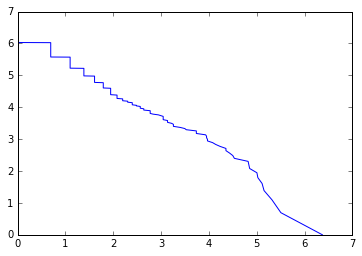

In [10]:
#Si cumple con la ley de zipf la representación sigte será aprox una recta.
t = arange(1,1001,1)
logf = log(dist3)
logt = log(t)
plot(logf,logt)

### 3er paso: Generar una distribución normal a partir de Zeta.

Este paso es una propuesta personal a partir de la oscuridad en el artículo de Luhn 
[[2](#Luhn1958)] con respecto a los bordes de corte. Algunos artículos consideran
que en la determinación de estos límites hay cierto empirismo. Los cálculos se hacen
utilizando una hipótesis nula 
[Keith web book, chapter2](http://www.dcs.gla.ac.uk/Keith/Chapter.2/Ch.2.html)/
[inlink](./htmls/3.1/Keith_Ch2/index.html).

31 133


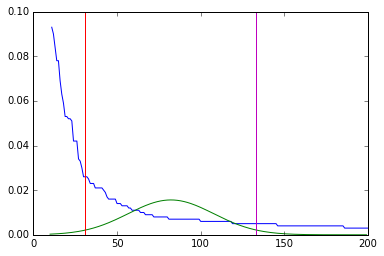

82.1780440434 25.5430146811


In [11]:
import matplotlib.pyplot as plt

bins = np.arange(0,1000,1)
dist4 = dist3/float(1000)
#Ploting Zipf distribution
plt.plot(t[10:200],dist4[10:200])
sigma = dist3.std()
mu = dist3.mean()+3*sigma
pdf = (1/(sigma * numpy.sqrt(2 * numpy.pi))
* numpy.exp( - (bins - mu)**2 / (2 * sigma**2) ))

#Ploting density function
plt.plot(bins[10:200],pdf[10:200])

perc_05 = int(mu-2*sigma)
perc_95 = int(mu+2*sigma)
print(perc_05, perc_95)
# Dibujando la línea discontínua del lower cut-off.
plt.axvline(perc_05,label='05 perc',c='r')
# Dibujando la línea discontínua del upper cut-off.
plt.axvline(perc_95,label='95t perc',c='m')
plt.show()
print (mu, sigma)

## Must Important Words

In [12]:
print (tupla1[-perc_05][1],":",tupla1[-perc_05][0])
print (tupla1[-perc_95][1],":",tupla1[-perc_95][0])
print ('All important words:', tupla1[len(tupla1)-perc_95:len(tupla1)-perc_05+1])

also : 130
battle : 54
All important words: [[54, 'battle'], [54, 'book'], [54, 'market'], [55, 'industry'], [55, 'money'], [55, 'search'], [55, 'small'], [56, 'biggest'], [56, 'bugs'], [57, 'around'], [57, 'available'], [57, 'didn'], [57, 'music'], [58, 'back'], [58, 'development'], [58, 'go'], [58, 'isn'], [58, 'us'], [58, 'working'], [60, 'companies'], [60, 'source'], [61, 'file'], [61, 'user'], [62, 'best'], [62, 'information'], [62, 'think'], [63, 'lot'], [63, 'want'], [64, 'right'], [64, 'standard'], [64, 'sun'], [64, 'therefore'], [64, 'write'], [65, 'idea'], [65, 'times'], [66, 'drivers'], [66, 'part'], [66, 'standards'], [67, 'cost'], [68, 'copyright'], [68, 'written'], [69, 'applications'], [69, 'built'], [69, 'without'], [70, 'company'], [70, 'data'], [71, 'format'], [72, 'building'], [72, 'driver'], [72, 'operating'], [72, 'patents'], [72, 'programming'], [73, 'still'], [73, 'used'], [73, 'using'], [73, 'yet'], [74, 'create'], [75, 'run'], [76, 'computers'], [76, 'features'

Este método es ampliamente utilizado en la generación de resúmenes automáticos. Puede
servir para dar un peso a las palabras dentro del documento, y extraer las estructuras
más ponderadas: oraciones, párrafos, etc. Como es posible observar en el 
ejemplo del libro "After de Software Wars", este método deja de 102721 palabras solo 
unas 200 significativas.

## References

[1] *[Bird2009]* Steven Bird, Ewan Klain & Edward Loper,. 
Book **Natural Language Processing with Python**. 2009. 
p. 10 **ISBN**: 978-0-596-51649-9

[2] *[Luhn1958]* H.P. Luhn. Paper **The Automatic Creation of Literature Abstract**. 
*IBM Journal*, 1958.

## Alphabetic Index

**Token**: señal, indicio, muestra. Se usa generalmente para referirse a la unidad
más pequeña de procesamiento: palabras, fonemas, n-grams, etc..